In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

100
100


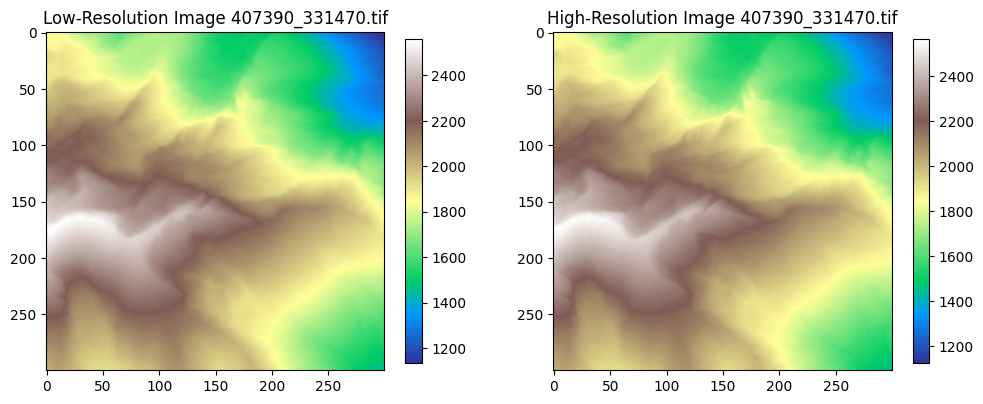

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.64212	valid_1's rmse: 3.57799
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.64212	valid_1's rmse: 3.57799
Fold 1: RMSE = 3.5779927109678
Fold 1: RMSEi = 3.5779927109678
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.72523	valid_1's rmse: 3.72366
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.72523	valid_1's rmse: 3.72366
Fold 2: RMSE = 3.723664262239351
Fold 2: RMSEi = 3.723664262239351
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.70034	valid_1's rmse: 3.77768
Training until validation scores don't improve for

In [2]:
import os 
import glob 
import pandas as pd 
import numpy as np 
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

PATH = '/kaggle/input/super-resolution-austria-dtm-fastai/austria_dtm_fastai'
os.listdir(PATH)


data_100 = os.path.join(PATH,'data_100')
data_test_100 = os.path.join(PATH,'data_test_100')
data = os.path.join(PATH,'data0')

data_100_dpath_lr_us_cc = os.path.join(data_100, 'lr_us_cc') 
data_100_dpath_lr_hr = os.path.join(data_100, 'hr') 
data_100_dpath_lr_lr = os.path.join(data_100, 'lr') 
data_100_dpath_lr_us_nn = os.path.join(data_100, 'lr_us_nn') 

fs_lr_us_cc = glob.glob(f'{data_100_dpath_lr_us_cc}/*.tif'); print(len(fs_lr_us_cc))
fs_hr = glob.glob(f'{data_100_dpath_lr_hr}/*.tif'); print(len(fs_hr))

def load_raster(path):
    with rasterio.open(path) as src: return src.read(1)
#         da = src.read(1, masked=True)
#         ndv = src.nodata
#         da[da==ndv] = np.nan
 #   return da 
def images_to_df(dal,dah):
    df = pd.DataFrame()
    df['lr'] = dal.flatten()
    df['hr'] = dah.flatten()
    return df



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Assuming `load_raster` is defined somewhere to load raster data
# Also assuming `fs_lr_us_cc` and `fs_hr` are defined lists of file paths

cmap = 'terrain'
idx = np.random.randint(0, len(fs_lr_us_cc))
dal = load_raster(fs_lr_us_cc[idx])
dah = load_raster(fs_hr[idx])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the low-resolution image
im1 = ax[0].imshow(dal, cmap=cmap, norm=Normalize(vmin=dal.min(), vmax=dal.max()))
fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=0.7)
ax[0].set_title(f'Low-Resolution Image {os.path.basename(fs_lr_us_cc[idx])}')

# Display the high-resolution image
im2 = ax[1].imshow(dah, cmap=cmap, norm=Normalize(vmin=dah.min(), vmax=dah.max()))
fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=0.7)
ax[1].set_title(f'High-Resolution Image {os.path.basename(fs_hr[idx])}')

plt.show()

dlist = []
for i in range(len(fs_lr_us_cc)):
    dal = load_raster(fs_lr_us_cc[idx])
    dah = load_raster(fs_hr[idx])
    dlist.append(images_to_df(dal,dah))
df = pd.concat(dlist, ignore_index=False)
d1 = images_to_df(dal,dah)


dft, dfv = train_test_split(d1, test_size=0.25, random_state=130222)
# dive the files public and private
#train,valid : pub
#calib, test: priv
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
import numpy as np
from pprint import pprint
# Define the holdout split function
def holdout_split(X, Y, tsize=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=tsize, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

# Perform the holdout split
X_train, X_test, y_train, y_test = holdout_split(d1[['lr']], d1['hr'], tsize=0.1)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=3, random_state=42, shuffle=True)

# DataFrame to collect metrics
#metrics_df = pd.DataFrame(columns=['modelname', 'score', 'modelpath'])

metrics_ld = []
# Iterate through each fold
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_kf_train, X_kf_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize LightGBM dataset
    train_data = lgb.Dataset(X_kf_train, label=y_kf_train)
    valid_data = lgb.Dataset(X_kf_test, label=y_kf_test, reference=train_data)
    
    # Define LightGBM parameters (you can adjust these parameters)
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }
    
    # Train the model
    bst = lgb.train(params, train_data, num_boost_round=100, 
                    valid_sets=[train_data, valid_data], 
                    callbacks=[lgb.early_stopping(50)])
    
    bst_i = lgb.train(params, train_data, num_boost_round=100, 
                    valid_sets=[train_data, valid_data], 
                      keep_training_booster=True,
                    callbacks=[lgb.early_stopping(50)])
    
    # Predict on the validation set
    y_pred = bst.predict(X_kf_test, num_iteration=bst.best_iteration)
    y_pred_i = bst_i.predict(X_kf_test, num_iteration=bst_i.best_iteration)
   
    
    # Evaluate the model (you can choose your metric)
    rmse = np.sqrt(np.mean((y_kf_test - y_pred)**2))
    model_name = f"model_fold_{i+1}"
    model_path = f"./{model_name}.txt"
    
    # Save the model
    bst.save_model(model_path)
    
    
   
    rmse_i = np.sqrt(np.mean((y_kf_test - y_pred_i)**2))
    model_name_i = 'modeli'
    model_path_i = f"./{model_name_i}.txt"
    bst_i.save_model(model_path)
    
    # Append the metrics to the DataFrame
    metrics_ld.append({'modelname': model_name, 'score': rmse, 'modelpath': model_path, 
                       'modelnamei':model_name_i, 'scorei': rmse_i, 'modelpathi': model_path_i}) 
                                 
    print(f"Fold {i+1}: RMSE = {rmse}")
    print(f"Fold {i+1}: RMSEi = {rmse_i}")

# After K-Fold cross-validation, you can train on the full training set and evaluate on the holdout set if needed
train_data_full = lgb.Dataset(X_train, label=y_train)
valid_data_full = lgb.Dataset(X_test, label=y_test, reference=train_data_full)

bst_full = lgb.train(params, train_data_full, num_boost_round=100, 
                     valid_sets=[train_data_full, valid_data_full], 
                     callbacks=[lgb.early_stopping(50)])

# should be able to load it : it appears like restarting the training
bst_i = lgb.train(params, train_data_full, num_boost_round=100, 
                     valid_sets=[train_data_full, valid_data_full], 
                      keep_training_booster=True,
                    callbacks=[lgb.early_stopping(50)])

# Predict on the holdout set
y_pred_full = bst_full.predict(X_test, num_iteration=bst_full.best_iteration)
y_pred_i = bst_i.predict(X_test, num_iteration=bst_i.best_iteration)

# Evaluate the model on the holdout set
rmse_full = np.sqrt(np.mean((y_test - y_pred_full)**2))
model_name_full = "model_full"
model_path_full = f"./{model_name_full}.txt"

rmse_i = np.sqrt(np.mean((y_test - y_pred_i)**2))
metrics_ld.append({'modelname': model_name_full, 'score': rmse_full, 'modelpath': model_path_full,
                  'modelnamei':model_name_i, 'scorei': rmse_i, 'modelpathi': model_path_i})
# Save the full model
bst_full.save_model(model_path_full)
bst_i.save_model(f"./model_i.txt")

# Append the holdout set metrics to the DataFrame
print(f"Holdout set RMSE = {rmse_full}")
print(f"Holdout set RMSEi = {rmse_i}")
mdf = pd.DataFrame(metrics_ld)
mdf.to_csv('model_name_error_path.csv')
# Display the DataFrame with all the metrics




In [3]:
# cont learninh

In [4]:
mdf

,modelname,score,modelpath,modelnamei,scorei,modelpathi
0,model_fold_1,3.577993,./model_fold_1.txt,modeli,3.577993,./modeli.txt
1,model_fold_2,3.723664,./model_fold_2.txt,modeli,3.723664,./modeli.txt
2,model_fold_3,3.777681,./model_fold_3.txt,modeli,3.777681,./modeli.txt
3,model_full,3.689476,./model_full.txt,modeli,3.689476,./modeli.txt
